In [31]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import shutil
import numpy as np
import random

In [32]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [33]:
data_path ='/kaggle/input/genderclassification/Dataset '
os.listdir(data_path)

['gender_classification.xlsx',
 'list_attribute.txt',
 'gender_classification.csv',
 'Images',
 'model_saved',
 'class_identity.txt',
 'list_attribute_new.txt']

In [34]:
images_list = os.listdir(data_path+'/Images')
images_list = [image for image in images_list if len(image.split('(')) <= 1]

In [35]:
data = pd.read_csv(data_path+"/list_attribute_new.txt", sep='\s+')
data =  data[data["202599"].isin(images_list)]
data = data[["202599", "Male"]]
data["Male"] = data["Male"].replace(-1, 0)
data.rename(columns={'202599': 'Image'}, inplace=True)

In [36]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
train_data.reset_index(inplace = True, drop = True)

In [37]:
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)
val_data.reset_index(inplace = True, drop = True)
test_data.reset_index(inplace = True, drop = True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Male', ylabel='Count'>

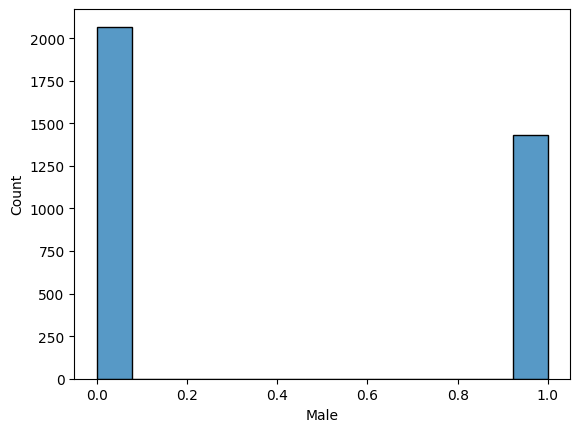

In [38]:
import seaborn as sns

sns.histplot(train_data["Male"])

In [39]:
train_data["Male"].value_counts()

Male
0    2067
1    1433
Name: count, dtype: int64

In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   3500 non-null   object
 1   Male    3500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.8+ KB


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Male', ylabel='Count'>

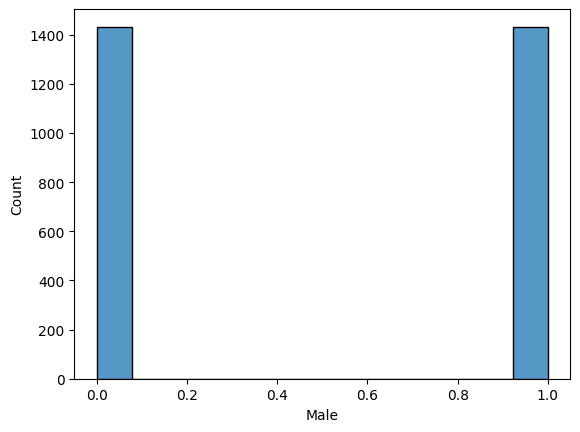

In [41]:
sample = train_data[train_data["Male"]==0].sample(n=len(train_data[train_data["Male"]==0])-len(train_data[train_data["Male"]==1]), random_state=2)
train_data = train_data[train_data["Image"].isin(sample["Image"]) == False]
train_data.reset_index(inplace=True,drop=True)
sns.histplot(train_data["Male"])

In [42]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2866 entries, 0 to 2865
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   2866 non-null   object
 1   Male    2866 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.9+ KB


In [43]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        # please define image convertion technique to RGB here
        image = Image.open(image_path).convert('RGB')
        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [44]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [45]:
train_set = GenderDataset(train_data, image_folder_path=data_path+"/Images", transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
# train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

val_set = GenderDataset(val_data, image_folder_path=data_path+"/Images", transform=transform)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

test_set = GenderDataset(test_data, image_folder_path=data_path+"/Images", transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [46]:
import time
from torch.autograd import Variable

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, epochs=10):
  # please define the training model (VGG/GoogleNet/ResNet) here
  # Train the model
    losses = []
    train_acc = []
    val_acc = []

    loss_freq = 20
    start_time = time.time()
    best_acc = 0
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloaders["train"], 0):
            # Get the inputs
            inputs, labels = data

            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            outputs = outputs.squeeze(1)
            # m = nn.Sigmoid()
            # outputs = m(outputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % loss_freq == loss_freq-1:
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / loss_freq))
                running_loss = 0.0

        losses.append(running_loss / np.mod(len(dataloaders["train"]), loss_freq))
        print(f'Epoch-{epoch+1} loss: {running_loss / np.mod(len(dataloaders["train"]), loss_freq)}')

        acc = calc_acc(model, dataloaders, epoch, "train")
        train_acc.append(acc)
        acc = calc_acc(model, dataloaders, epoch, "validation")
        val_acc.append(acc)

        training_time = time.time()-start_time
        print(f'Training time elapsed: {training_time}')
        print("=====================================================================================\n")
        torch.cuda.empty_cache()
    print(f'Total training time: {training_time}')
    print(f'Training time per epoch: {training_time/epoch+1}')
    torch.cuda.empty_cache()

    return losses, train_acc, val_acc

In [47]:
def calc_acc(model, dataloaders, epoch, mode):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders[mode]:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            outputs = outputs.squeeze(1)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_acc = 100 * correct / total

    print(f'{mode} accuracy: {epoch_acc}%')
    return epoch_acc

In [48]:
dataloaders = {
    "train":train_loader, "validation":val_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "validation":len(val_set), "test":len(test_set)
}

In [49]:
use_gpu = torch.cuda.is_available()
model_vgg16_bn = models.vgg16_bn()
model_vgg16_bn.classifier[6] = nn.Linear(4096, 1)
optimizer = optim.Adam(model_vgg16_bn.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
if use_gpu:
    model_vgg16_bn = model_vgg16_bn.cuda()
model_vgg16_bn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [50]:
loss, train_acc, val_acc = train_model(model_vgg16_bn, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, 10)


[1,    20] loss: 1.293
[1,    40] loss: 0.756
[1,    60] loss: 0.735
[1,    80] loss: 0.657
Epoch-1 loss: 0.6878158271312713
train accuracy: 66.78297278436845%
validation accuracy: 67.86666666666666%
Training time elapsed: 103.1362657546997

[2,    20] loss: 0.642
[2,    40] loss: 0.678
[2,    60] loss: 0.589
[2,    80] loss: 0.479
Epoch-2 loss: 0.5001889407634735
train accuracy: 77.70411723656665%
validation accuracy: 77.06666666666666%
Training time elapsed: 205.00737166404724

[3,    20] loss: 0.486
[3,    40] loss: 0.454
[3,    60] loss: 0.432
[3,    80] loss: 0.480
Epoch-3 loss: 0.5256600841879845
train accuracy: 79.37892533147243%
validation accuracy: 81.06666666666666%
Training time elapsed: 307.2339050769806

[4,    20] loss: 0.456
[4,    40] loss: 0.395
[4,    60] loss: 0.382
[4,    80] loss: 0.376
Epoch-4 loss: 0.320968434214592
train accuracy: 87.96231681786462%
validation accuracy: 88.0%
Training time elapsed: 409.3268506526947

[5,    20] loss: 0.265
[5,    40] loss: 0.287

In [51]:
def plot_train(loss, train_acc, val_acc):
    x = np.arange(0,10,1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(x, train_acc, color='r', label='train acc')
    ax[0].plot(x, val_acc, color='b', label='val acc')
    ax[0].set_xlabel("Epoch(s)")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_title("Accuracy per epoch")
    ax[0].legend()

    ax[1].plot(x, loss, color='r', label='loss')
    ax[1].set_xlabel("Epoch(s)")
    ax[1].set_ylabel("Loss")
    ax[1].set_title("Loss per epoch")
    ax[1].legend()

    plt.show

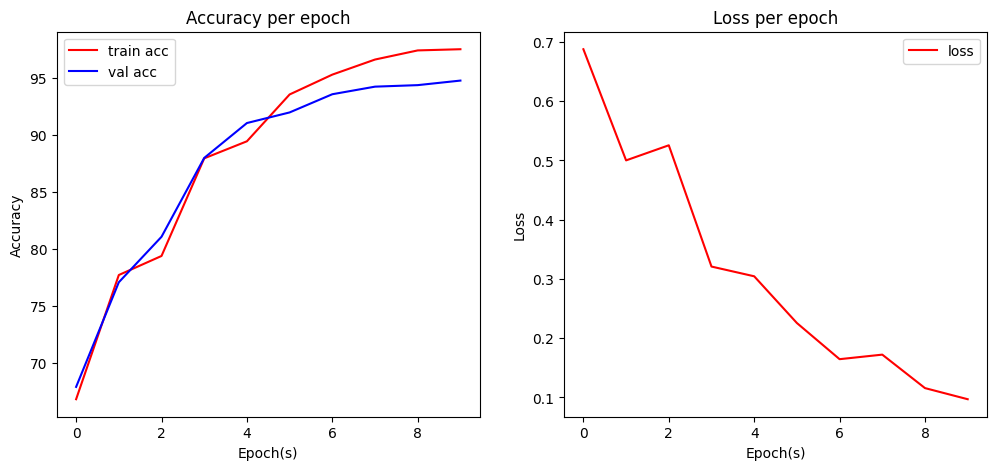

In [52]:
plot_train(loss, train_acc, val_acc)

In [53]:
# torch.save(model_vgg16_bn.state_dict(), data_path+"/vgg16_bn.pth")

In [54]:
def make_predict(model, dataloaders):
    start_time = time.time()
    y_true = torch.empty((0)).to('cuda')
    y_pred = torch.empty((0)).to('cuda')
    for data in dataloaders:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        outputs = outputs.squeeze(1)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        y_true = torch.cat((y_true, labels),-1)
        y_pred = torch.cat((y_pred, predicted),-1)
    inf_time = (time.time() - start_time)/len(dataloaders)
    return inf_time, y_true, y_pred

In [55]:
inf_vgg16_bn, ytrue_vgg16_bn, ypred_vgg16_bn = make_predict(model_vgg16_bn, dataloaders["test"])

In [56]:
ytrue_vgg16_bn = ytrue_vgg16_bn.cpu().numpy()
ypred_vgg16_bn = ypred_vgg16_bn.cpu().numpy()
print(classification_report(ytrue_vgg16_bn, ypred_vgg16_bn, digits = 4))
print("Inference Time of Model: {}".format(inf_vgg16_bn))
torch.cuda.empty_cache()

              precision    recall  f1-score   support

         0.0     0.9470    0.9427    0.9448       436
         1.0     0.9209    0.9268    0.9238       314

    accuracy                         0.9360       750
   macro avg     0.9339    0.9347    0.9343       750
weighted avg     0.9361    0.9360    0.9360       750

Inference Time of Model: 0.22338881095250449


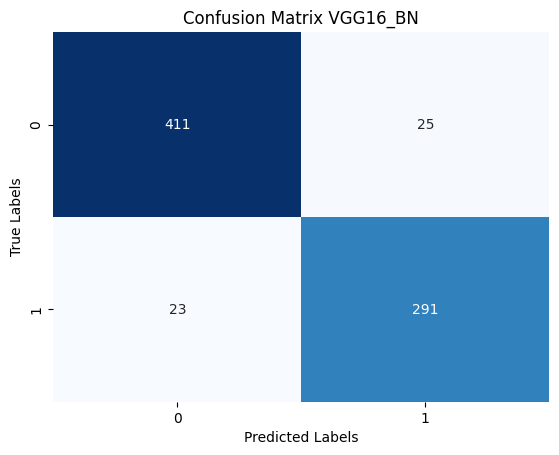

In [57]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytrue_vgg16_bn, ypred_vgg16_bn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix VGG16_BN')
plt.show()

In [58]:
model_vgg19_bn = models.vgg19_bn()
model_vgg19_bn.classifier[6] = nn.Linear(4096, 1)
optimizer = optim.Adam(model_vgg19_bn.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
if use_gpu:
    model_vgg19_bn = model_vgg19_bn.cuda()
model_vgg19_bn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [59]:
loss, train_acc, val_acc = train_model(model_vgg19_bn, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, 10)


[1,    20] loss: 1.006
[1,    40] loss: 0.861
[1,    60] loss: 0.756
[1,    80] loss: 0.700
Epoch-1 loss: 0.7091459393501282
train accuracy: 72.85415212840195%
validation accuracy: 73.2%
Training time elapsed: 117.52304434776306

[2,    20] loss: 0.502
[2,    40] loss: 0.567
[2,    60] loss: 0.507
[2,    80] loss: 0.486
Epoch-2 loss: 0.44047468304634096
train accuracy: 76.58757850662946%
validation accuracy: 74.0%
Training time elapsed: 235.36346554756165

[3,    20] loss: 0.514
[3,    40] loss: 0.444
[3,    60] loss: 0.397
[3,    80] loss: 0.426
Epoch-3 loss: 0.5126516580581665
train accuracy: 84.0195394277739%
validation accuracy: 83.46666666666667%
Training time elapsed: 353.354544878006

[4,    20] loss: 0.394
[4,    40] loss: 0.362
[4,    60] loss: 0.343
[4,    80] loss: 0.328
Epoch-4 loss: 0.31170411854982377
train accuracy: 89.77669225401256%
validation accuracy: 89.2%
Training time elapsed: 471.88292837142944

[5,    20] loss: 0.245
[5,    40] loss: 0.295
[5,    60] loss: 0.241

In [60]:
def plot_train(loss, train_acc, val_acc):
    x = np.arange(0,10,1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(x, train_acc, color='r', label='train acc')
    ax[0].plot(x, val_acc, color='b', label='val acc')
    ax[0].set_xlabel("Epoch(s)")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_title("Accuracy per epoch")
    ax[0].legend()

    ax[1].plot(x, loss, color='r', label='loss')
    ax[1].set_xlabel("Epoch(s)")
    ax[1].set_ylabel("Loss")
    ax[1].set_title("Loss per epoch")
    ax[1].legend()

    plt.show

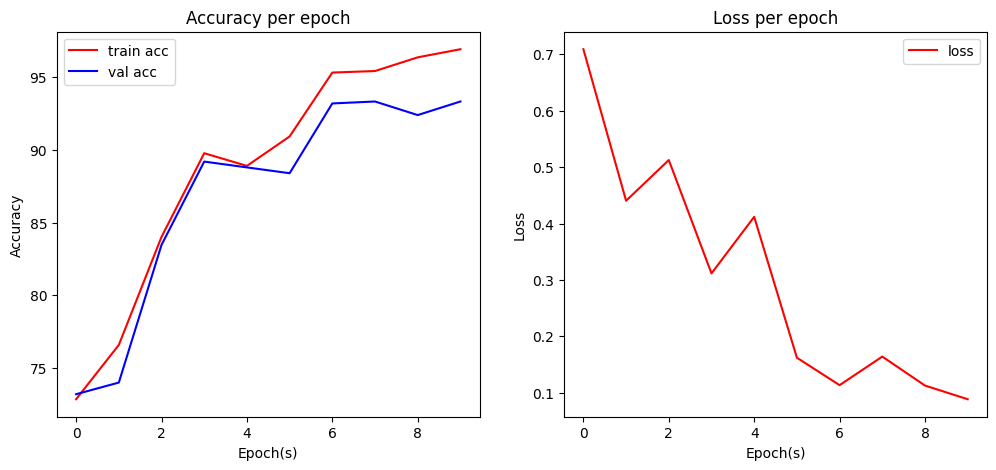

In [61]:
plot_train(loss, train_acc, val_acc)

In [62]:
# torch.save(model.state_dict(), project_path"/vgg19_bn.pth")

In [63]:
inf_vgg19_bn, ytrue_vgg19_bn, ypred_vgg19_bn = make_predict(model_vgg19_bn, dataloaders["test"])

In [64]:
ytrue_vgg19_bn = ytrue_vgg19_bn.cpu().numpy()
ypred_vgg19_bn = ypred_vgg19_bn.cpu().numpy()
print(classification_report(ytrue_vgg19_bn, ypred_vgg19_bn, digits = 4))
print("Inference Time of Model: {}".format(inf_vgg19_bn))
torch.cuda.empty_cache()

              precision    recall  f1-score   support

         0.0     0.9628    0.9495    0.9561       436
         1.0     0.9313    0.9490    0.9401       314

    accuracy                         0.9493       750
   macro avg     0.9470    0.9493    0.9481       750
weighted avg     0.9496    0.9493    0.9494       750

Inference Time of Model: 0.34142884612083435


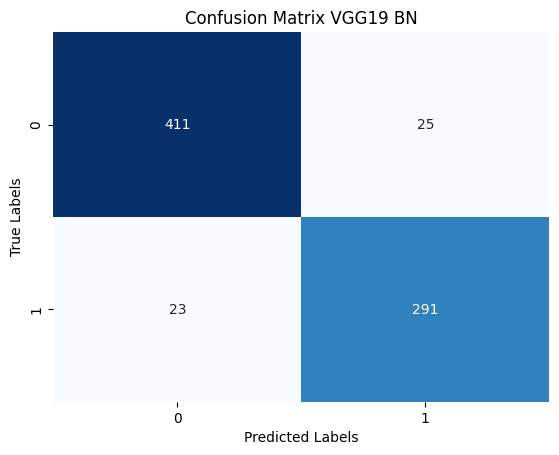

In [65]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytrue_vgg19_bn, ypred_vgg16_bn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix VGG19 BN')
plt.show()

In [ ]:
inf_vgg19_bn, ytrue_vgg19_bn, ypred_vgg19_bn = make_predict(model_vgg19_bn, dataloaders["test"])
ytrue_vgg19_bn = ytrue_vgg19_bn.cpu().numpy()
ypred_vgg19_bn = ytrue_vgg19_bn.cpu().numpy()
print(classification_report(ytrue_vgg19_bn, ypred_vgg19_bn, digits = 4))
print("Inference Time of Model: {}".format(inf_vgg19_bn))
torch.cuda.empty_cache()